In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "036"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks(surprise_bonus=3e-1))
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 300  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/56.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 02-22 16:55:29 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 16:55:31 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 16:55:31 api_server.py:841] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=No

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.05s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:02<00:02,  1.05s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.38it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.25it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.19it/s]



INFO 02-22 16:56:21 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 16:56:22 worker.py:267] Memory profiling takes 1.14 seconds
INFO 02-22 16:56:22 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 16:56:22 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 16:56:22 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 16:56:22 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 16:57:27 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 66.02 seconds
INFO 02-22 16:57:28 api_server.py:756] Using supplied chat template:
INFO 02-22 16:57:28 api_server.py:756] None
INFO 02-22 16:57:28 launcher.py:21] Available routes are:
INFO 02-22 16:57:28 launcher.py:29] Route: /

INFO:     Started server process [6445]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 16:57:30 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:58938 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [05:35<00:00,  7.62s/it, completion_tokens=333, prompt_tokens=1375, reward=0.173, acc=0.207, surprise=0.482, token_logprobs=1066942]


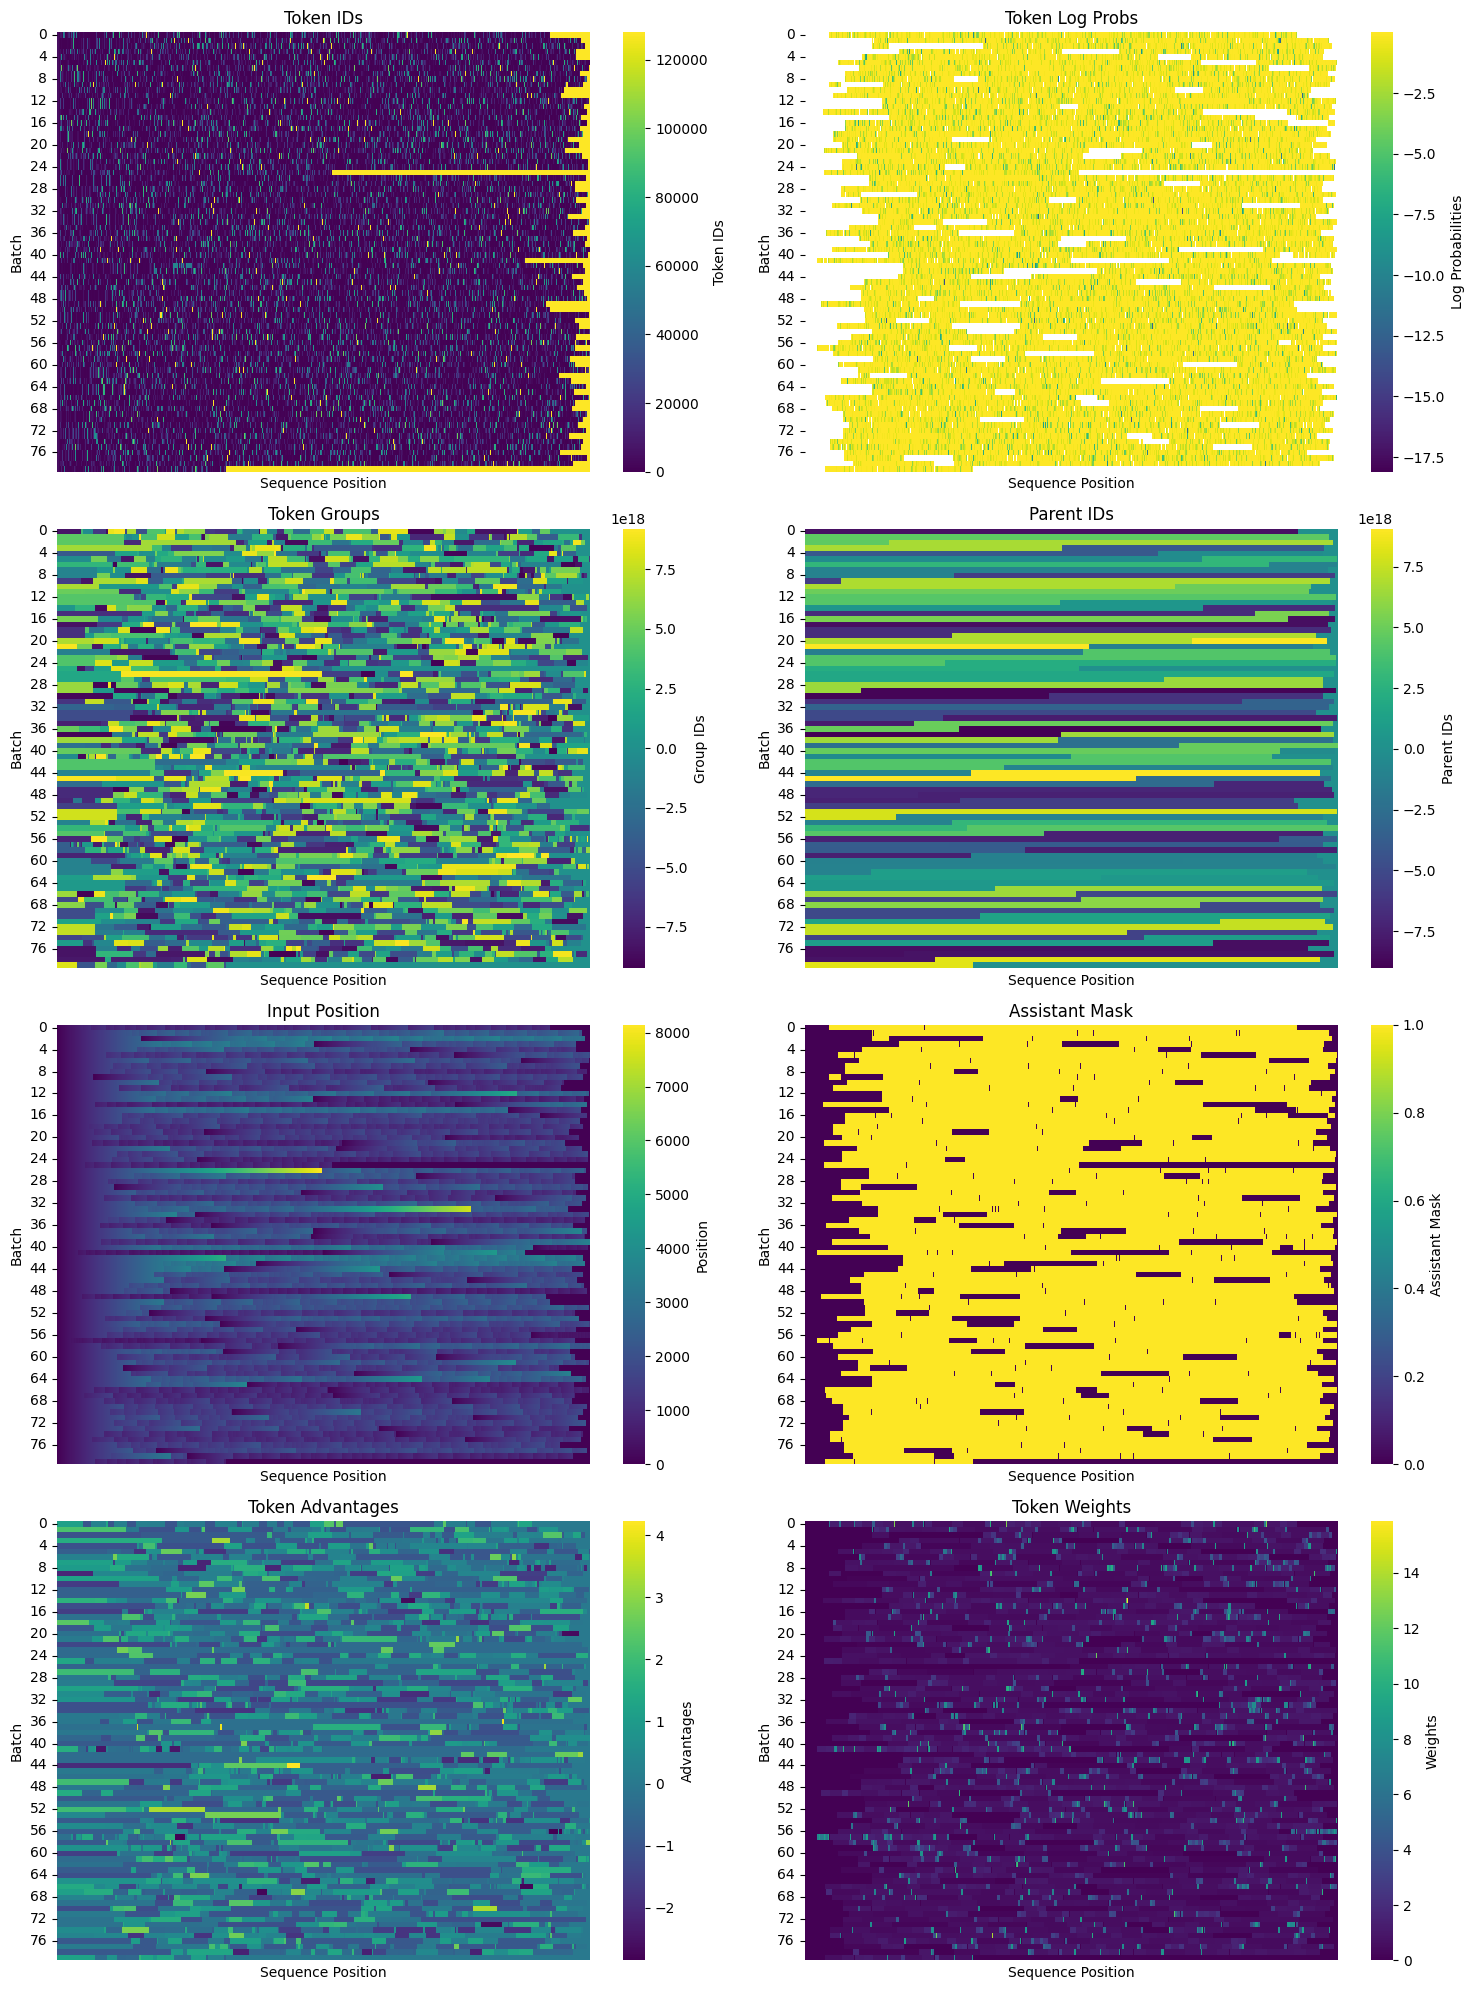

rsyncing /home/ubuntu/sky_workdir/experiments/models/036 to gs://atreides/openpipe/models/036
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/15a75279e8911d4c1f515986546f6fcb5ad0717c
Download complete. Moving file to /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/blobs/65efd9e0e3baa04473b66aa4ad473e9302cf7fc6
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/036/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725
  checkpoint_files:
  - model-00003-of-00004.safetensors
  - model-00001-of-00004.safetensors
  - model-00004-of-00004.safetensors
  - model-00002-of-00004.safetensors
  model_type: LLAMA3
  output_dir: ./models/036
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/036/tensors
  num_sequences: 80
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation

Writing logs to models/036/logs/log_1740243823.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.50 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|40|Loss: 0.0012: 100%|██████████| 40/40 [14:55<00:00, 21.58s/it, entropy=0.486, kl_div=nan, loss=0.0012, policy=0.0012]       INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #1 model files to ./models/036/0001
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/036/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/036/0001 --port=8000 --api-key=default
INFO 02-22 17:19:44 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 17:19:46 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 17:19:46 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/036/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.30s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.72s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:10<00:03,  3.88s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:14<00:00,  3.80s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:14<00:00,  3.62s/it]



INFO 02-22 17:20:18 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 17:20:20 worker.py:267] Memory profiling takes 0.94 seconds
INFO 02-22 17:20:20 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 17:20:20 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 17:20:20 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 17:20:20 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 17:21:14 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 55.68 seconds
INFO 02-22 17:21:15 api_server.py:756] Using supplied chat template:
INFO 02-22 17:21:15 api_server.py:756] None
INFO 02-22 17:21:15 launcher.py:21] Available routes are:
INFO 02-22 17:21:15 launcher.py:29] Route: /

INFO:     Started server process [9605]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 17:21:21 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-22 17:21:21 metrics.py:455] Avg prompt throughput: 1.7 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-22 17:21:21 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:44654 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:53<00:00, 100.90it/s, completion_tokens=48, prompt_tokens=1227, reward=0.249, acc=0.327, surprise=0.24, token_logprobs=154981]


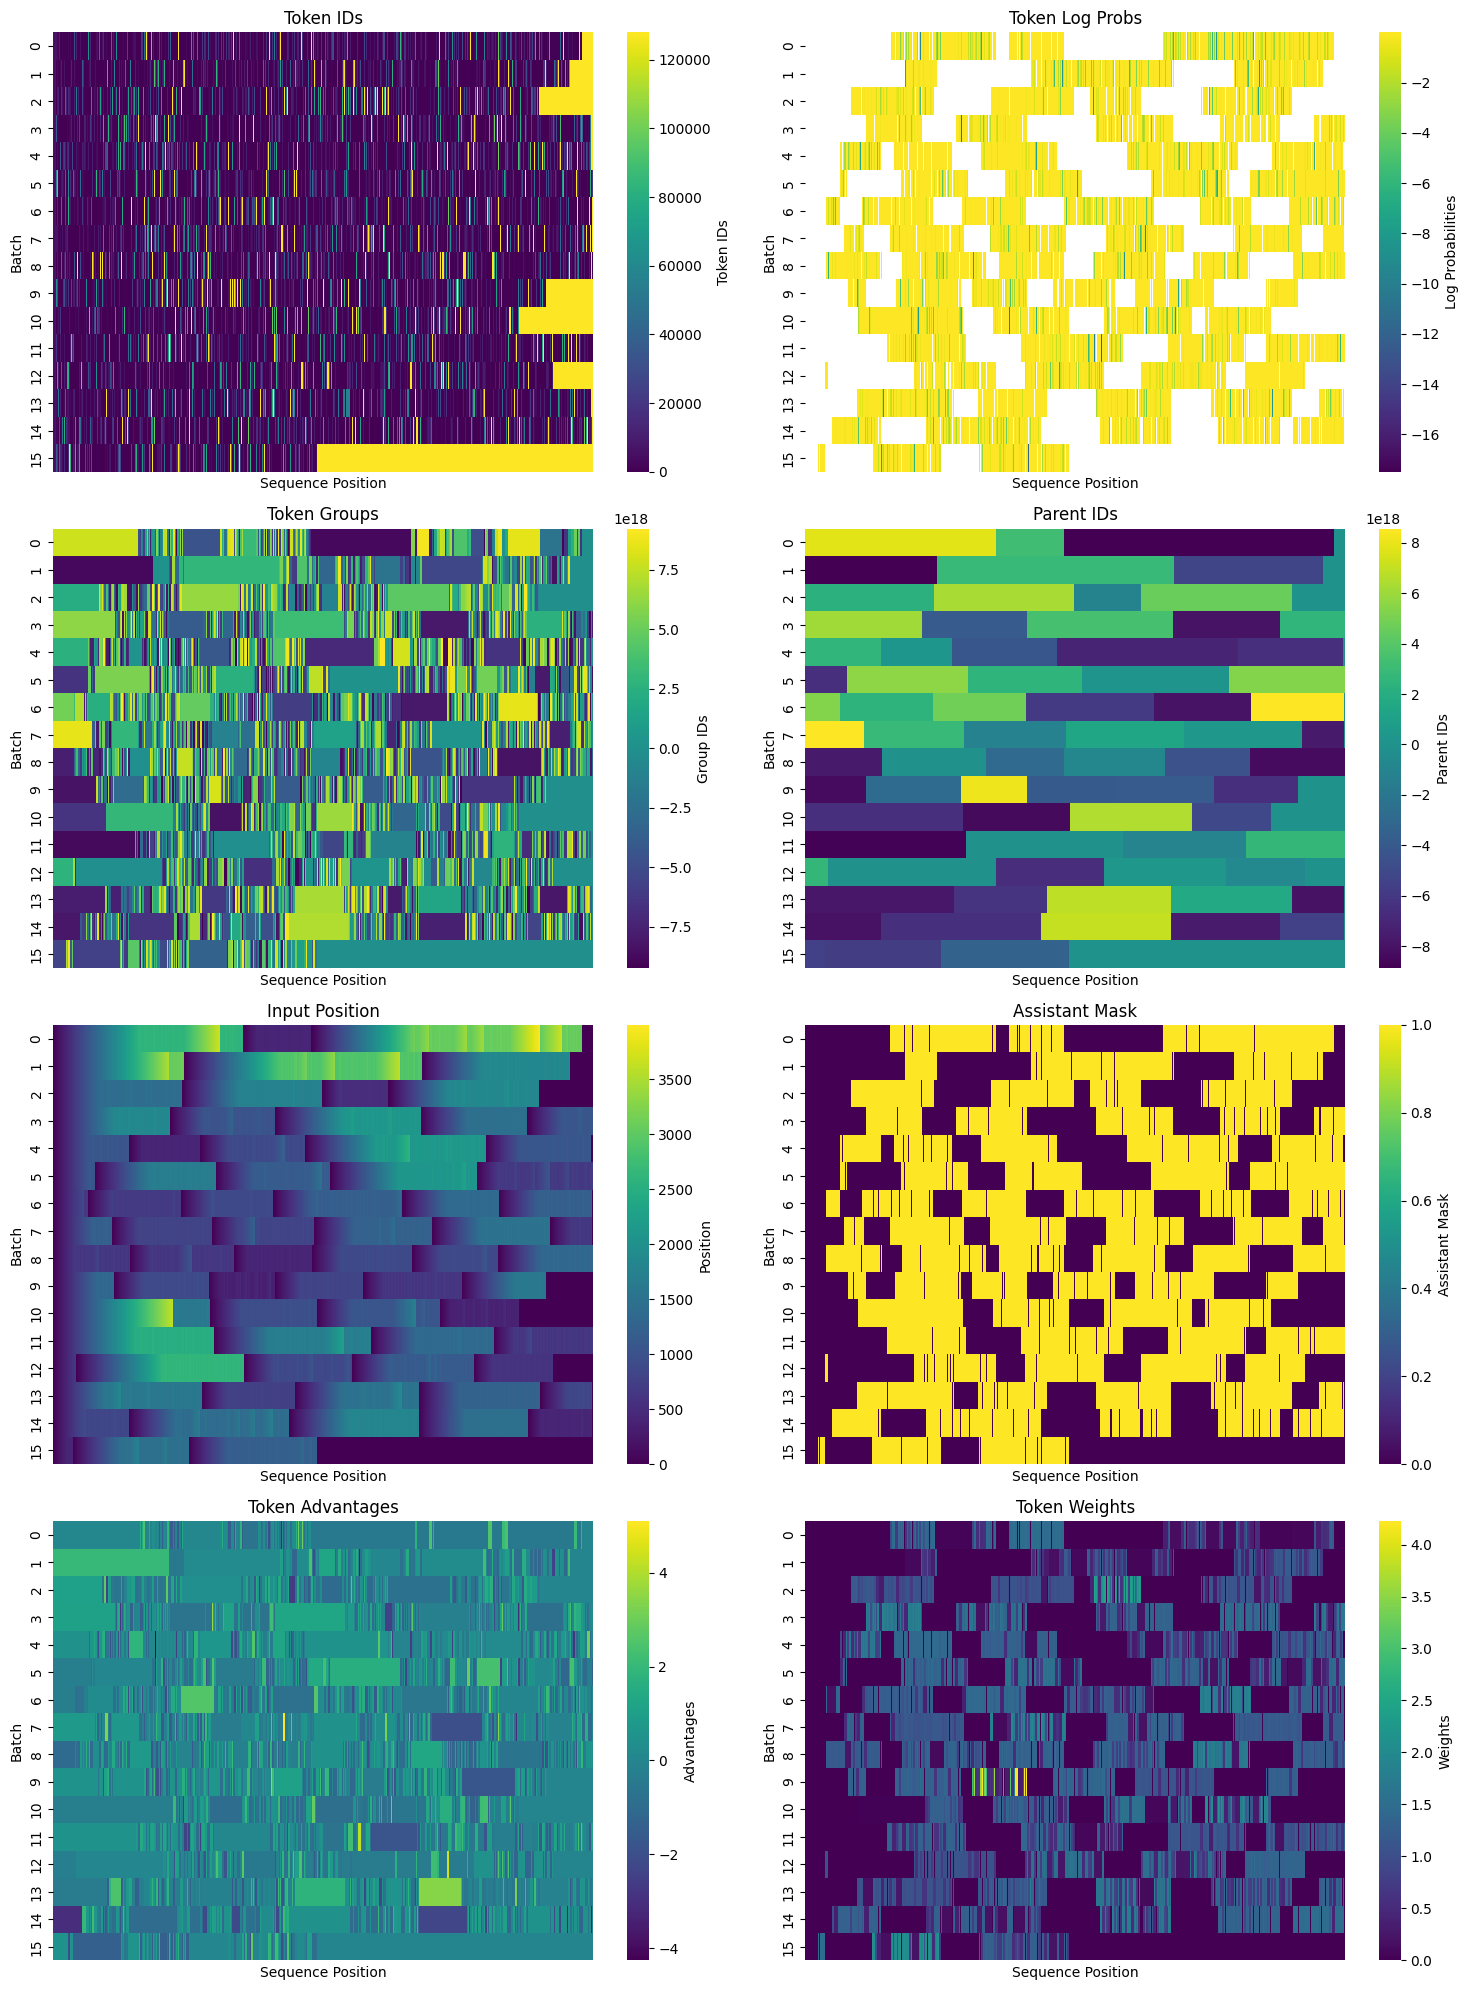

rsyncing /home/ubuntu/sky_workdir/experiments/models/036 to gs://atreides/openpipe/models/036
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/036/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/036/0001
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/036
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/036/tensors
  num_sequences: 16
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.tr

Writing logs to models/036/logs/log_1740245023.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.26 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|8|Loss: -0.0025: 100%|██████████| 8/8 [03:09<00:00, 22.02s/it, entropy=0.248, kl_div=nan, loss=-0.00254, policy=-0.00254]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
IN

Saved iteration #2 model files to ./models/036/0002
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/036/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/036/0002 --port=8000 --api-key=default
INFO 02-22 17:27:56 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 17:27:57 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 17:27:57 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/036/0002', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.28s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.61s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:11<00:04,  4.33s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:15<00:00,  4.13s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:15<00:00,  3.89s/it]



INFO 02-22 17:28:32 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 17:28:32 worker.py:267] Memory profiling takes 0.87 seconds
INFO 02-22 17:28:32 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 17:28:32 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 17:28:33 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 17:28:33 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 17:29:18 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.67 seconds
INFO 02-22 17:29:19 api_server.py:756] Using supplied chat template:
INFO 02-22 17:29:19 api_server.py:756] None
INFO 02-22 17:29:19 launcher.py:21] Available routes are:
INFO 02-22 17:29:19 launcher.py:29] Route: /

INFO:     Started server process [11549]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 17:29:21 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:48732 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:22<00:00, 13.93it/s, completion_tokens=122, prompt_tokens=1168, reward=0.322, acc=0.373, surprise=0.554, token_logprobs=391775]


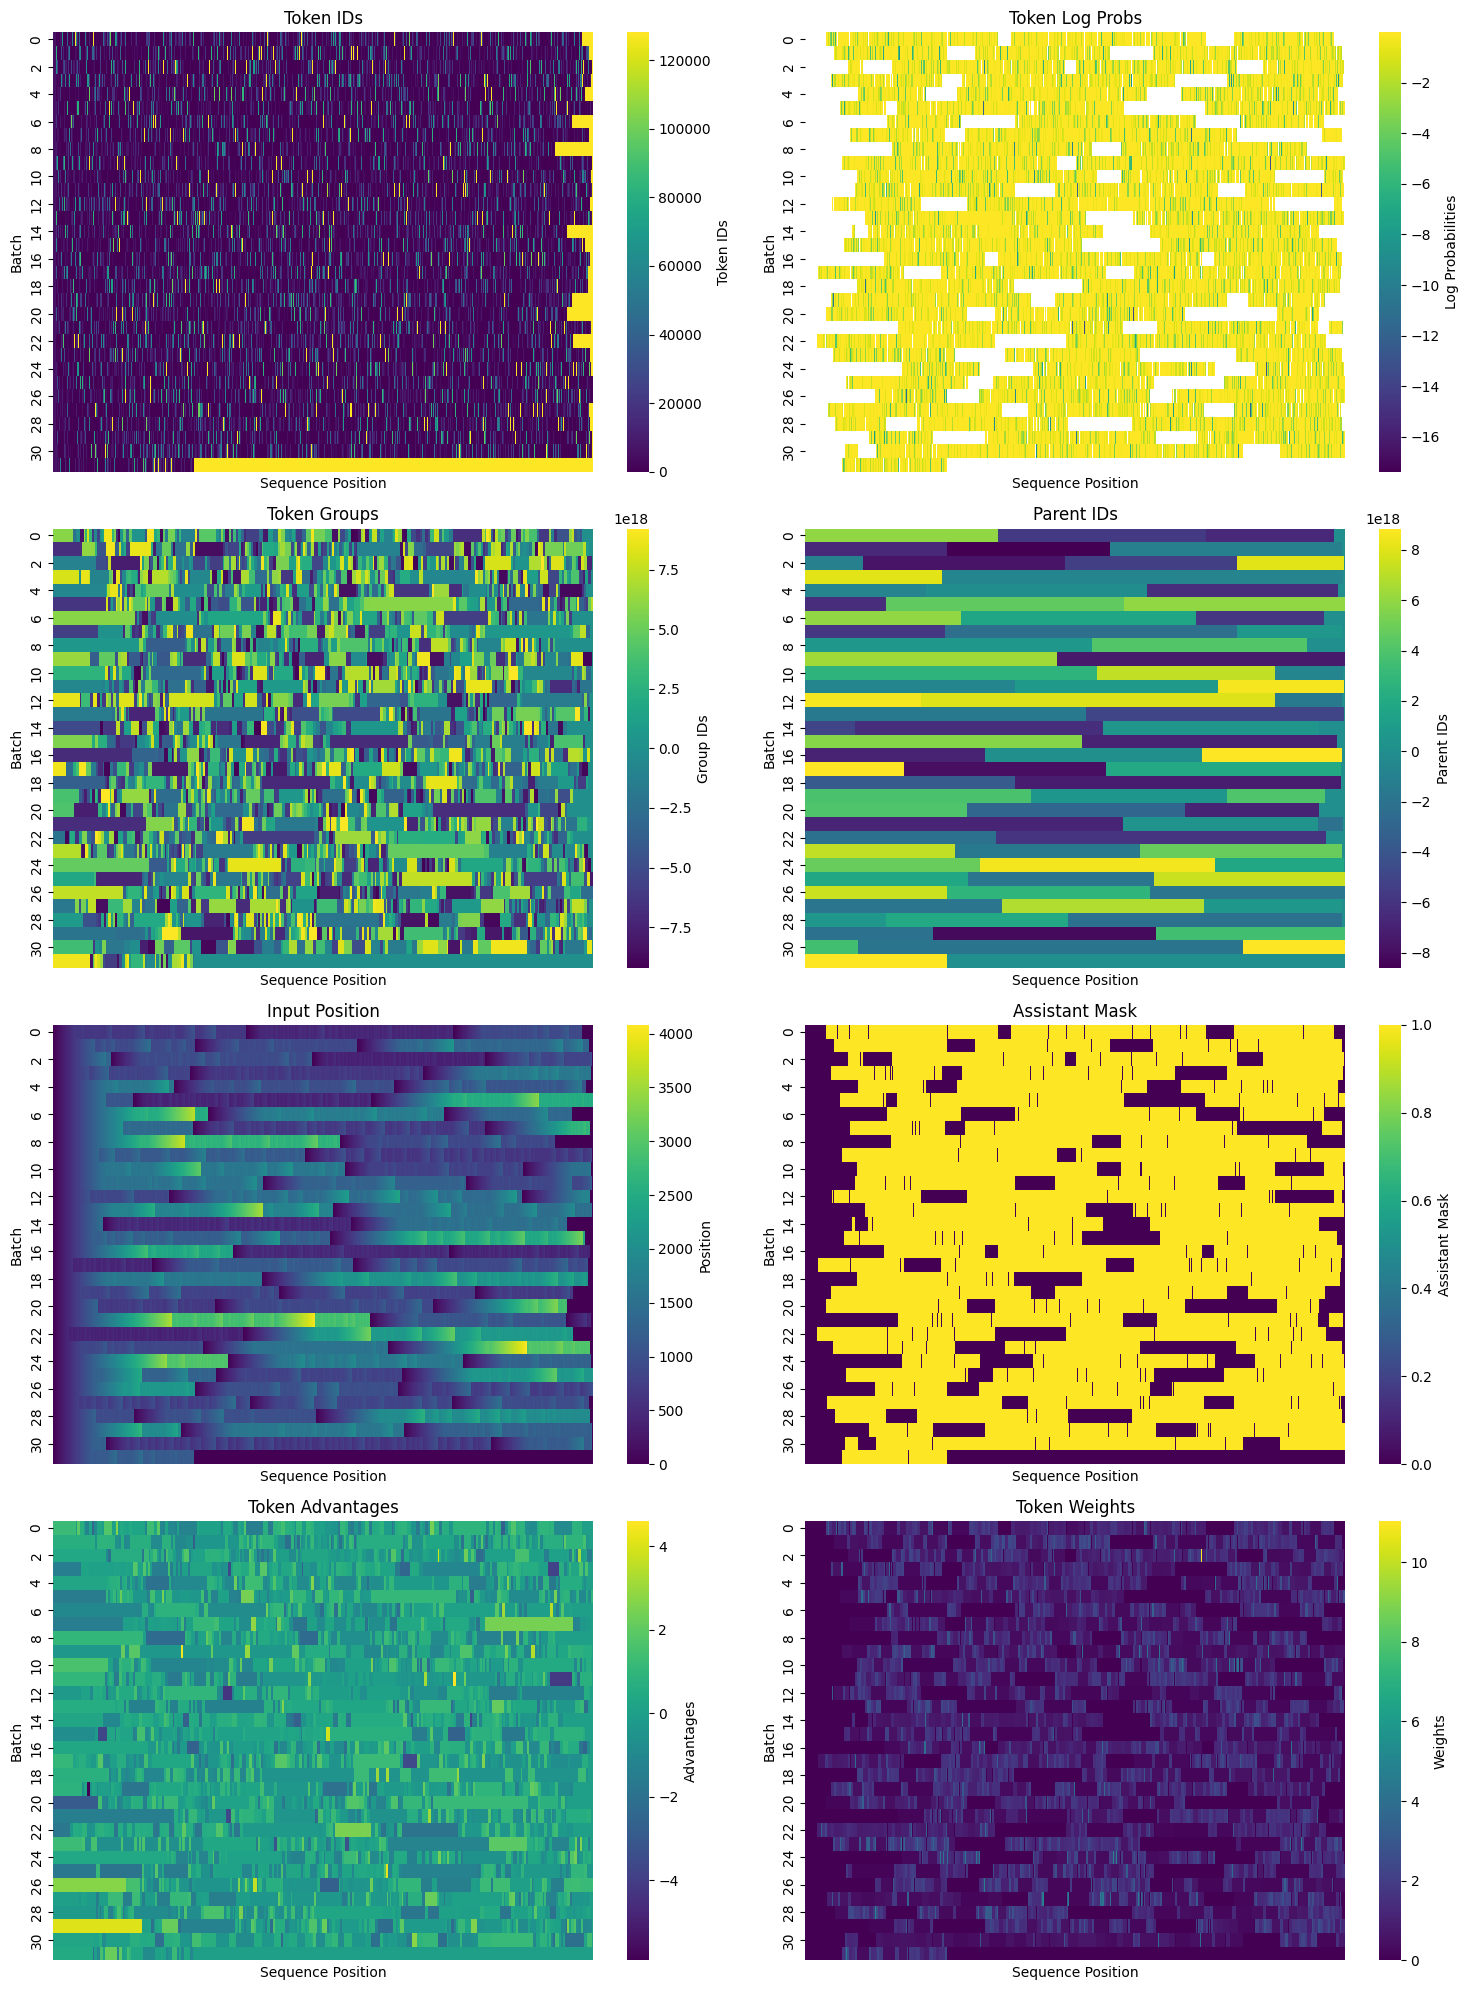

rsyncing /home/ubuntu/sky_workdir/experiments/models/036 to gs://atreides/openpipe/models/036
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/036/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/036/0002
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/036
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/036/tensors
  num_sequences: 32
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.tr

Writing logs to models/036/logs/log_1740245597.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 28.82 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|16|Loss: 0.0036: 100%|██████████| 16/16 [06:20<00:00, 21.65s/it, entropy=0.693, kl_div=nan, loss=0.00363, policy=0.00363]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict.

Saved iteration #3 model files to ./models/036/0003
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/036/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/036/0003 --port=8000 --api-key=default
INFO 02-22 17:40:56 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 17:40:57 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 17:40:57 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/036/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.53s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:10<00:03,  3.76s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:14<00:00,  3.74s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:14<00:00,  3.53s/it]



INFO 02-22 17:41:30 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 17:41:31 worker.py:267] Memory profiling takes 0.93 seconds
INFO 02-22 17:41:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 17:41:31 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 17:41:31 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 17:41:31 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 17:42:24 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 53.91 seconds
INFO 02-22 17:42:25 api_server.py:756] Using supplied chat template:
INFO 02-22 17:42:25 api_server.py:756] None
INFO 02-22 17:42:25 launcher.py:21] Available routes are:
INFO 02-22 17:42:25 launcher.py:29] Route: /

INFO:     Started server process [13550]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 17:42:26 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:33632 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:47<00:00, 14.36it/s, completion_tokens=151, prompt_tokens=1142, reward=0.379, acc=0.396, surprise=0.879, token_logprobs=484565]
Deleted iteration directory ./models/036/0001


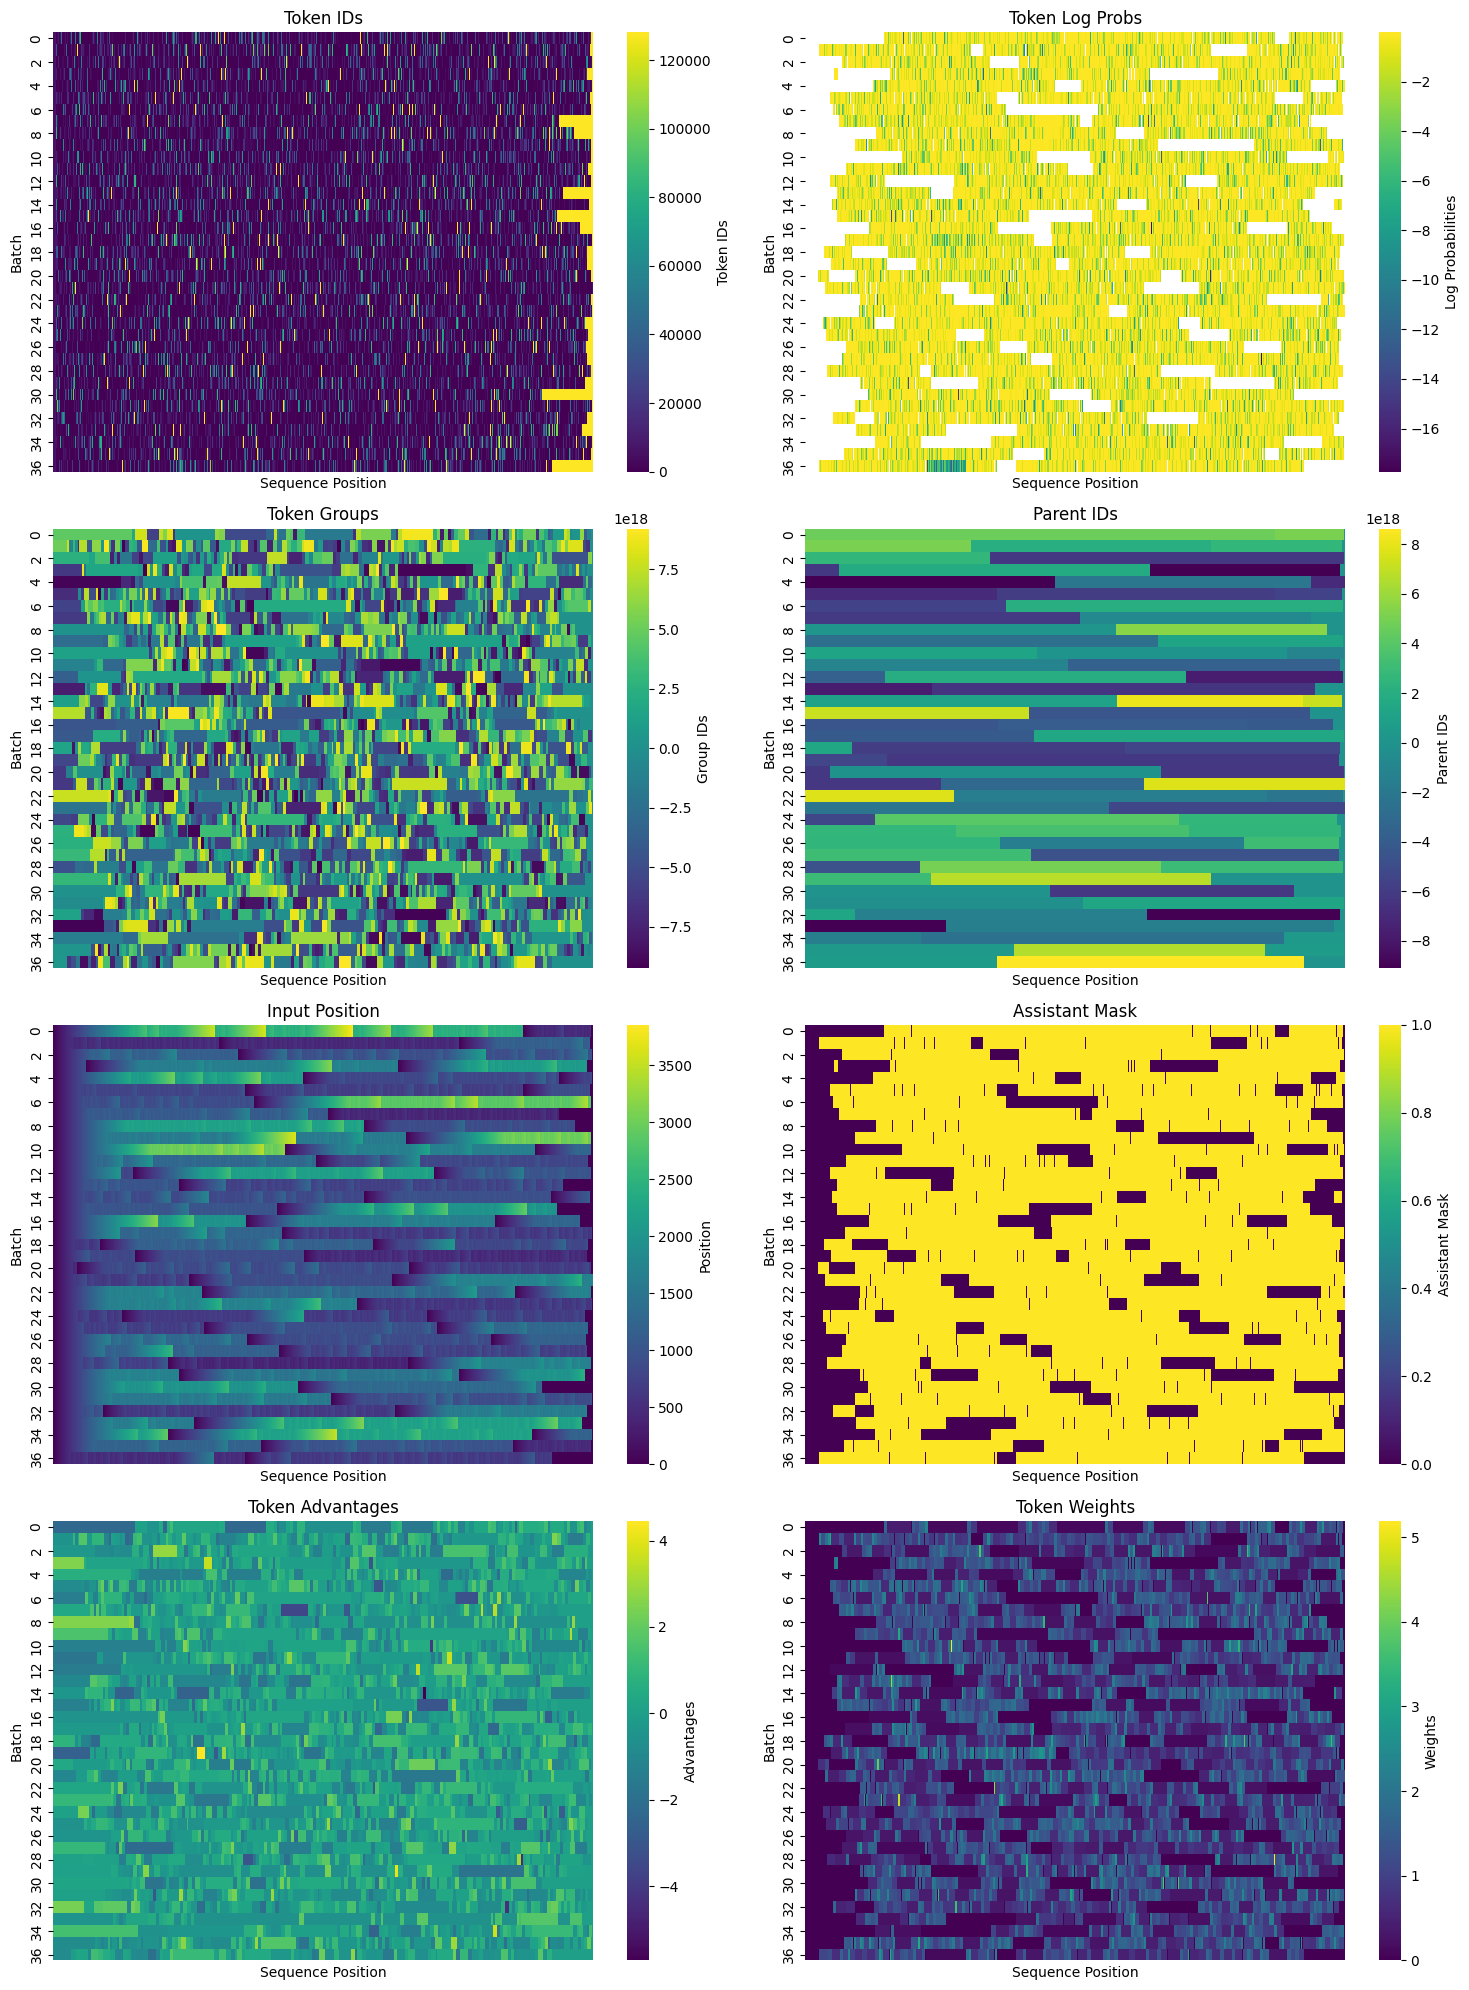

rsyncing /home/ubuntu/sky_workdir/experiments/models/036 to gs://atreides/openpipe/models/036
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/036/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/036/0003
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/036
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/036/tensors
  num_sequences: 37
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.tr

Writing logs to models/036/logs/log_1740246405.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 27.27 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|18|Loss: 0.0015: 100%|██████████| 18/18 [06:47<00:00, 21.74s/it, entropy=1.19, kl_div=nan, loss=0.00145, policy=0.00145]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INF

Saved iteration #4 model files to ./models/036/0004
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/036/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/036/0004 --port=8000 --api-key=default
INFO 02-22 17:54:44 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 17:54:46 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 17:54:46 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/036/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.02s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.50s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:10<00:03,  3.80s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:14<00:00,  3.84s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:14<00:00,  3.58s/it]



INFO 02-22 17:55:16 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 17:55:17 worker.py:267] Memory profiling takes 1.00 seconds
INFO 02-22 17:55:17 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 17:55:17 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 17:55:17 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 17:55:17 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 17:56:09 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 53.07 seconds
INFO 02-22 17:56:10 api_server.py:756] Using supplied chat template:
INFO 02-22 17:56:10 api_server.py:756] None
INFO 02-22 17:56:10 launcher.py:21] Available routes are:
INFO 02-22 17:56:10 launcher.py:29] Route: /

INFO:     Started server process [15605]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 17:56:12 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:46832 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:26<00:00,  1.47it/s, completion_tokens=149, prompt_tokens=1145, reward=0.446, acc=0.421, surprise=1.21, token_logprobs=477208]
Deleted iteration directory ./models/036/0002


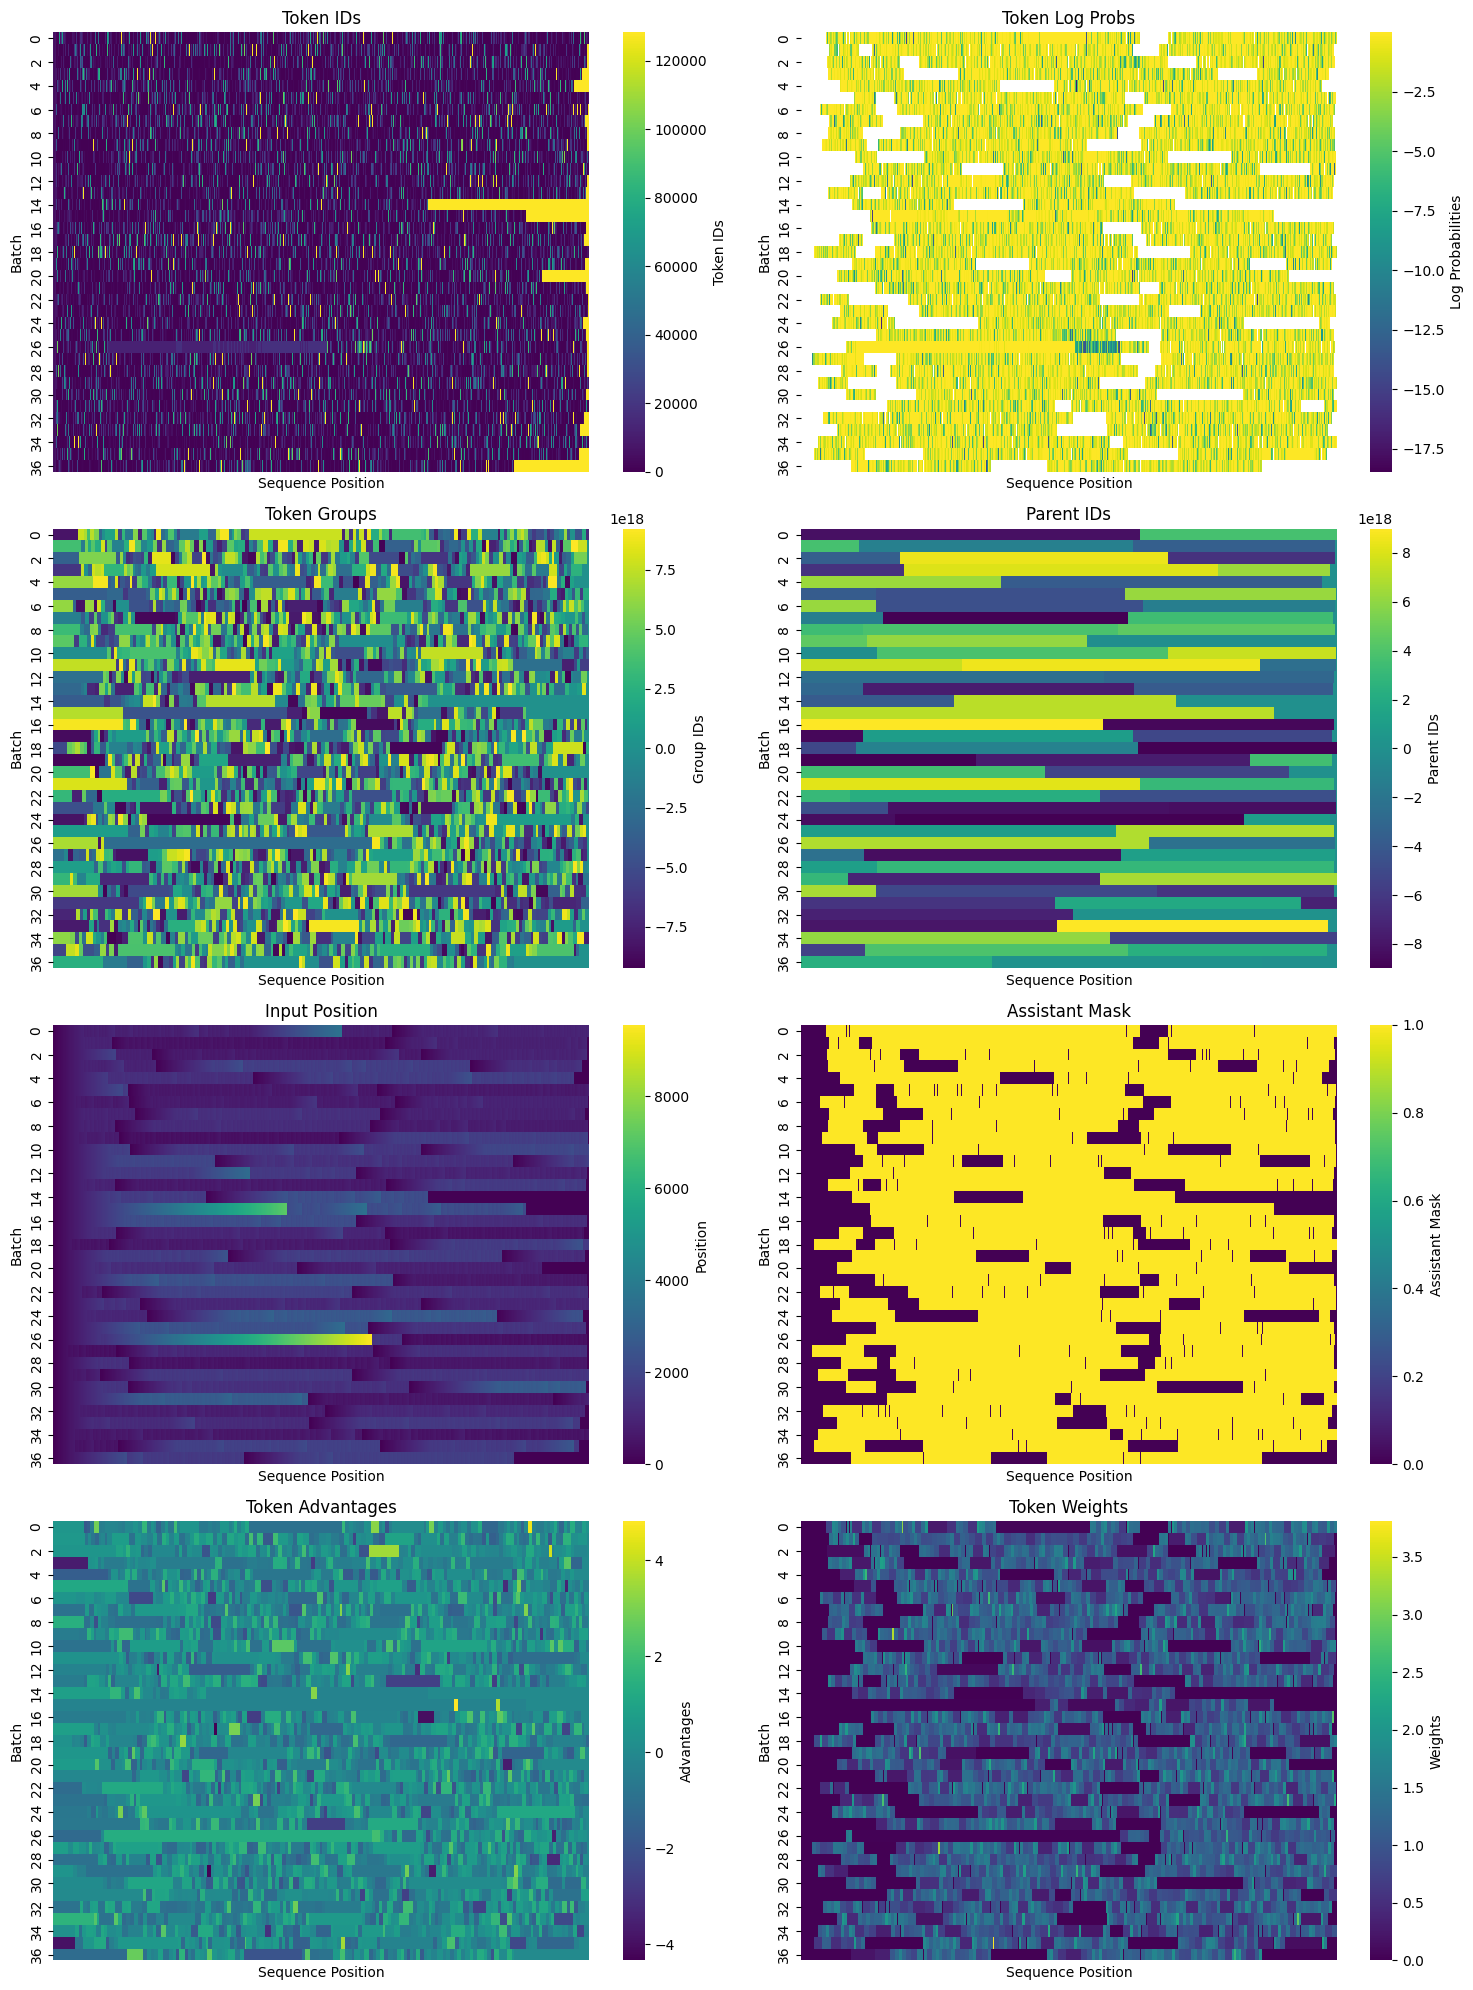

rsyncing /home/ubuntu/sky_workdir/experiments/models/036 to gs://atreides/openpipe/models/036
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/036/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/036/0004
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/036
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/036/tensors
  num_sequences: 37
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.tr

Writing logs to models/036/logs/log_1740247213.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 34.99 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|18|Loss: -0.0028: 100%|██████████| 18/18 [06:53<00:00, 21.62s/it, entropy=1.45, kl_div=nan, loss=-0.00283, policy=-0.00283]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...


Saved iteration #5 model files to ./models/036/0005
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/036/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/036/0005 --port=8000 --api-key=default
INFO 02-22 18:08:30 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 18:08:31 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 18:08:31 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/036/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.10it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:05,  2.69s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.09s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  3.04s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.84s/it]



INFO 02-22 18:08:56 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 18:08:57 worker.py:267] Memory profiling takes 0.89 seconds
INFO 02-22 18:08:57 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 18:08:57 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 18:08:57 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 18:08:57 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 18:09:43 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.03 seconds
INFO 02-22 18:09:44 api_server.py:756] Using supplied chat template:
INFO 02-22 18:09:44 api_server.py:756] None
INFO 02-22 18:09:44 launcher.py:21] Available routes are:
INFO 02-22 18:09:44 launcher.py:29] Route: /

INFO:     Started server process [17577]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 18:09:49 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-22 18:09:49 metrics.py:455] Avg prompt throughput: 1.7 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-22 18:09:49 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:48954 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [09:28<00:00,  2.15it/s, completion_tokens=409, prompt_tokens=1297, reward=0.523, acc=0.397, surprise=2.09, token_logprobs=1308283]
Deleted iteration directory ./models/036/0003


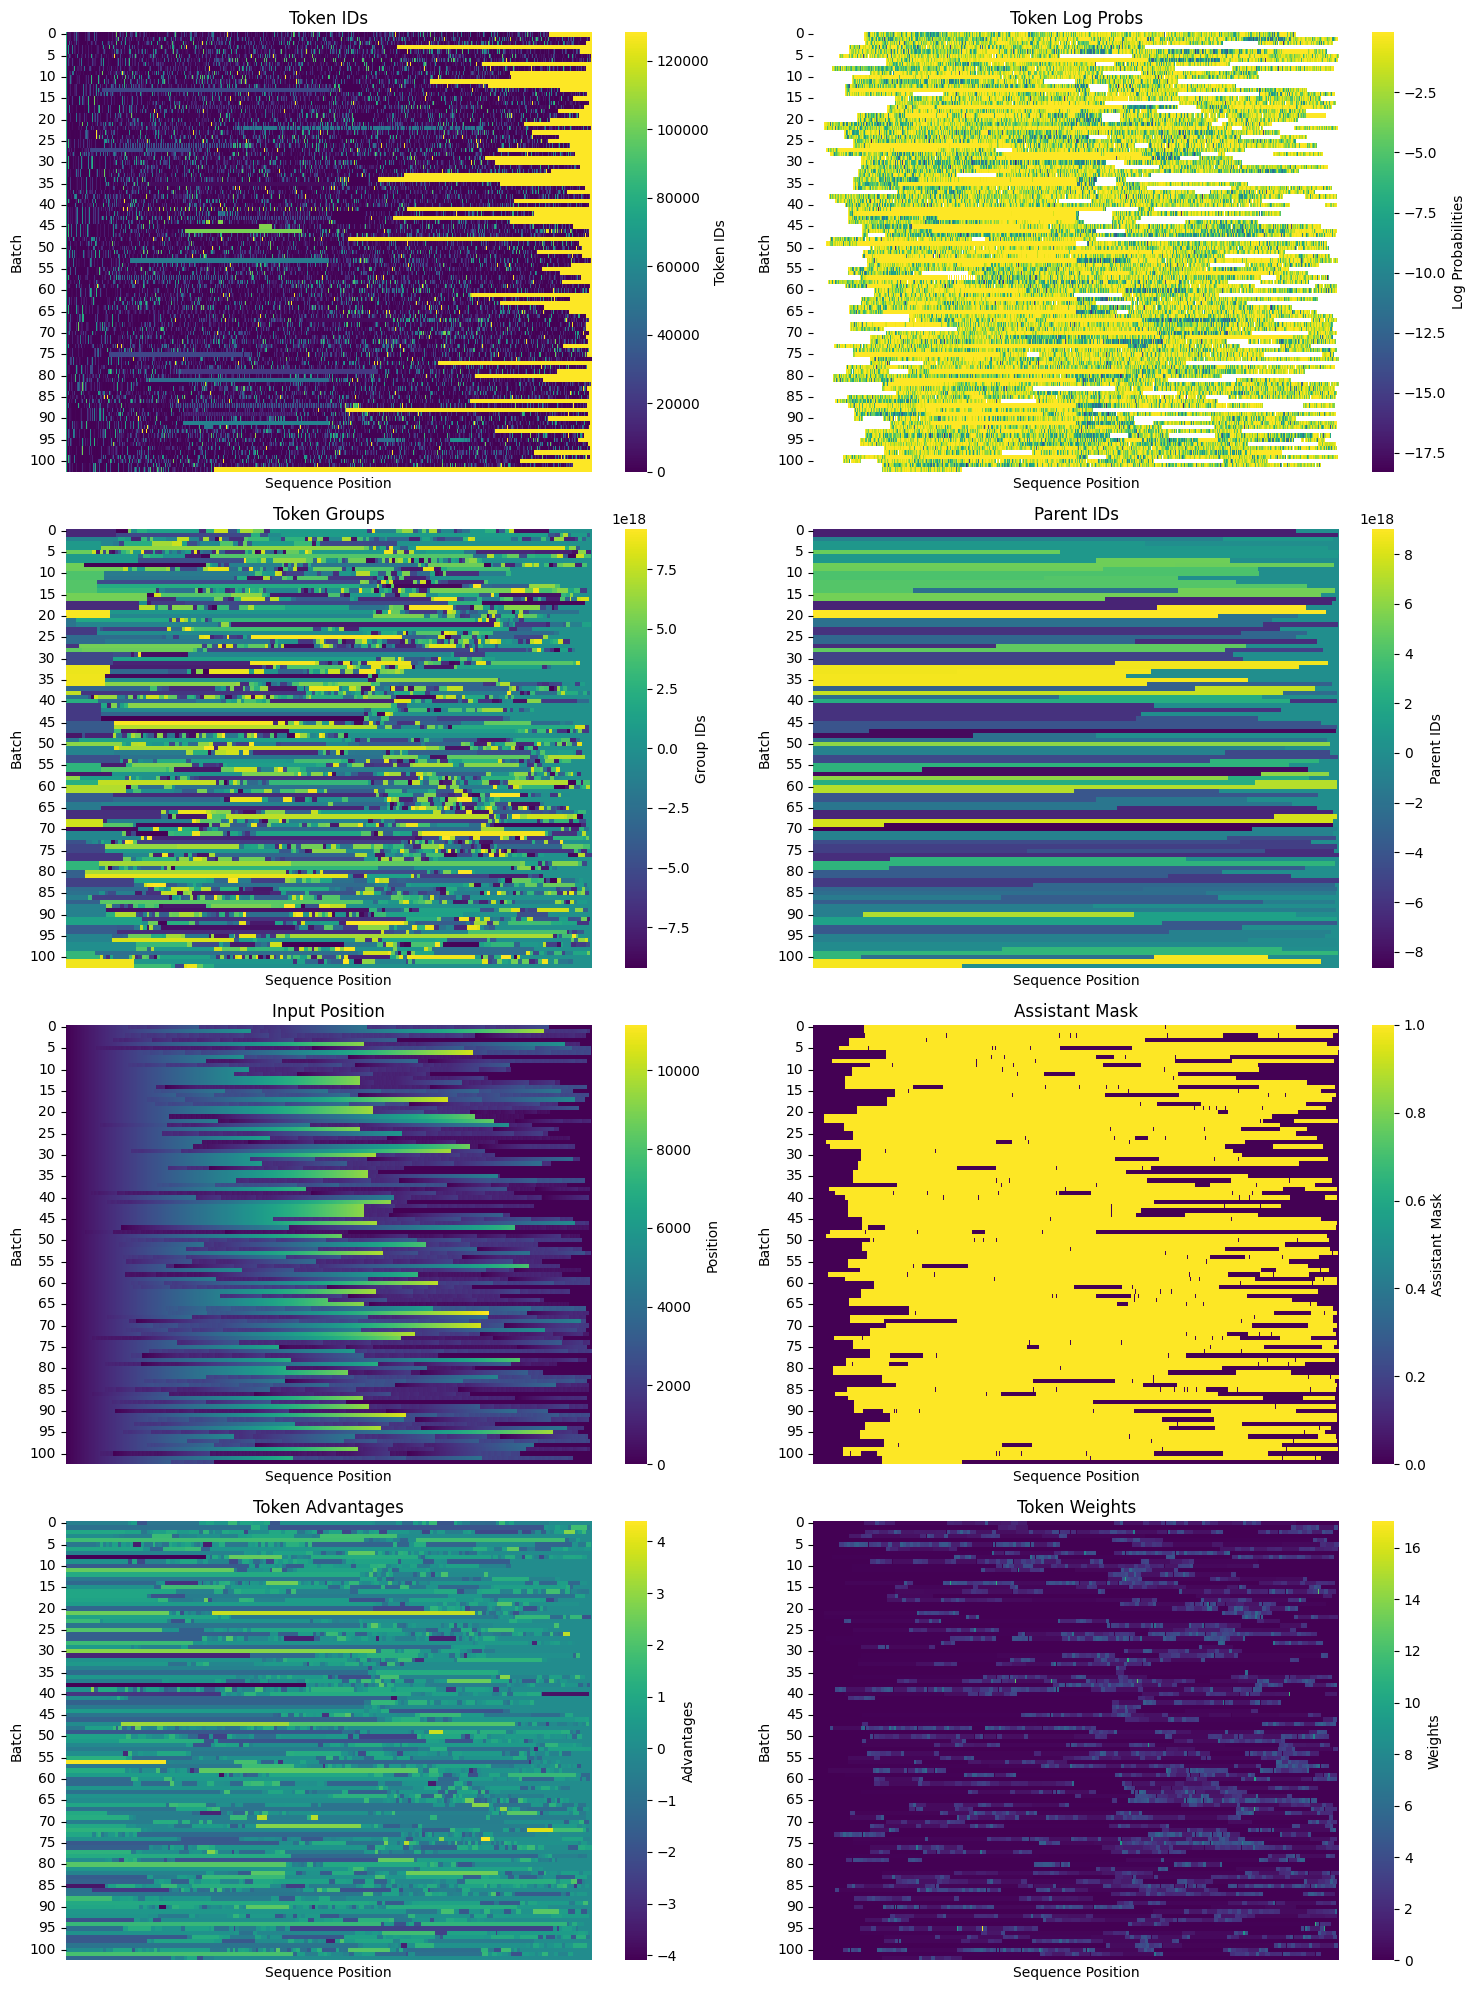

rsyncing /home/ubuntu/sky_workdir/experiments/models/036 to gs://atreides/openpipe/models/036
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/036/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/036/0005
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/036
  recipe_checkpoint: null
compile: true
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/036/tensors
  num_sequences: 103
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.t

Writing logs to models/036/logs/log_1740248400.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...


AssertionError: No model checkpoint files found to save in output directory ./models/036

In [5]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
            compile=True,
        ),
        verbosity=verbosity,
    )

In [9]:
result = max(tokenized_results, key=lambda result: len(result.token_logprobs))

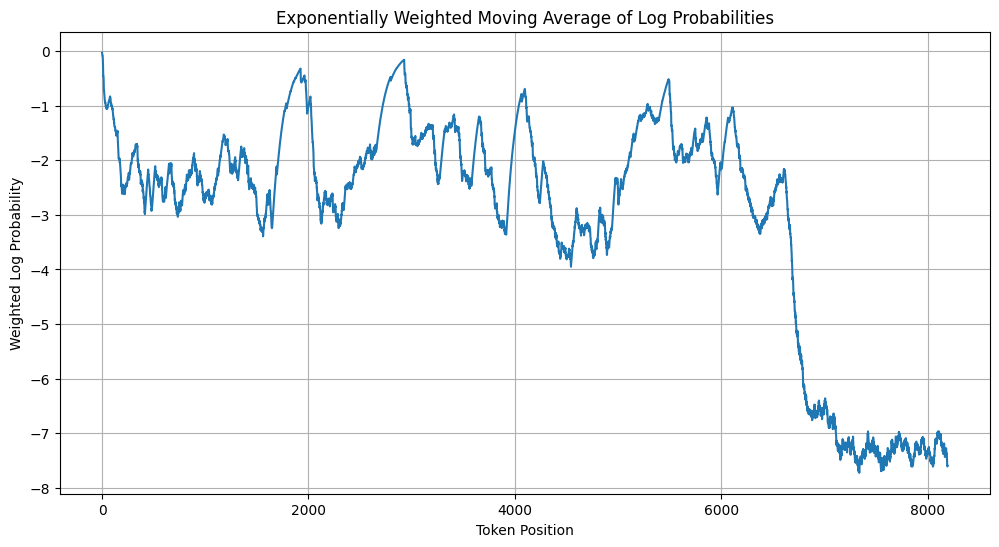

In [32]:
def weighted_logprobs(result):
    weighted_logprob = 0
    alpha = 0.99
    for token_logprob in result.token_logprobs:
        weighted_logprob = (
            alpha * weighted_logprob + (1 - alpha) * token_logprob.logprob
        )
        yield weighted_logprob


ewm_logprobs = list(weighted_logprobs(result))
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ewm_logprobs)
plt.title('Exponentially Weighted Moving Average of Log Probabilities')
plt.xlabel('Token Position')
plt.ylabel('Weighted Log Probability')
plt.grid(True)
plt.show()


In [29]:
print(
    b"".join(
        bytes(token_logprob.bytes or []) for token_logprob in result.token_logprobs[:800]
    ).decode()
)

This problem is an example of a classic, invitational advanced Sudokus with a CSI-Differentiation. Too many possibilities to enumerate them by hands, a computer program is likely the only practical solution. Here is a simplified version of the solution:

A. Monsieur Brunette
B. Rope
C. Drawing Room
D. Ambition
E. Fear
F. Drawing Room

Note that the solution becomes more complex when you want to fill in all the rooms and times, as there would be 132 different possibilities and a simple enumeration is likely to take days. Indeed, listing the suspects and the weapons, we get the list below, which would require 132 columns! To solve this, a computer program is the way to go._apps/CLI_Color_Code_Windows/b373911e-6e6e-42c3-b547-39e86ae62db4.jpx.png draining a little bit of sanity. ). See this working solution for more details: https://pastebin.com/1nBYd55T. The clues are very rich, providing a lot of information about the movements of the suspect and the weapons. With all the possibilities s